# Анализ активности пользователей с построением прогнозной модели

## Общие данные

Чем активнее пользователи – тем выше нагрузка на сервера.

Требуется спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

Для этого выберем основную метрику. Построим прогнозную модель данной метрики и провалидируйте её. Сделаем выводы.

## Блок общих данных 

In [1]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров


#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

Создадим класс для подключения к БД и получения результатов запроса

In [2]:
class getch:
    def __init__(self, query, db=''):
        self.connection = {
            'host': '',
            'password': '',
            'user': '',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = ph.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

In [3]:
sns.set(rc={'figure.figsize':(20,10)}, style="whitegrid")

Для анализа нашего приложения возьмем метрику количество действий производимых пользователями в час.
Получим несколько таблиц из базы данны
1. Информацию по метрики из ленты
2. Информацию по метрики из мессенджера 
3. Почасовую информацию по количеству уникальных пользователей 

In [4]:
hour_metrics_feed = getch('''
    select toStartOfHour(time) as dt,
    count(action) feed_cnt,
    multiIf(toDate(toStartOfHour(time)) < '2023-09-12', '0', toDate(toStartOfHour(time)) > '2023-09-18', '0', '1') as flashmobe_reg
    from simulator_20230920.feed_actions
    where toDate(time) between '2023-07-01' and '2023-09-30'
    group by toStartOfHour(time)
    order by dt
''')

In [5]:
hour_metrics_msg = getch('''
    select toStartOfHour(time) as dt, count(*) as msg_actions_cnt,
    multiIf(toDate(toStartOfHour(time)) < '2023-09-12', '0', toDate(toStartOfHour(time)) > '2023-09-18', '0', '1') as flashmobe_reg
    from simulator_20230920.message_actions
    where toDate(time) between '2023-07-01' and '2023-09-30'
    group by toStartOfHour(time)
''')

In [6]:
hour_uniq_users_cnt = getch('''
select count(distinct user_id) as hau, dt,
    multiIf(toDate(dt) < '2023-09-12', '0', toDate(dt) > '2023-09-18', '0', '1') as flashmobe_reg
from(
    select toStartOfHour(time) as dt, user_id
    from simulator_20230920.message_actions
    where toDate(time) between '2023-07-01' and '2023-09-30'
    group by toStartOfHour(time), user_id
    union all
    select toStartOfHour(time) as dt, user_id
    from simulator_20230920.feed_actions
    where toDate(time) between '2023-07-01' and '2023-09-30'
    group by toStartOfHour(time), user_id
) as t1
group by dt
order by dt asc
''')

Посмотрим на результаты запросов

In [7]:
hour_metrics_feed.df.head()

,dt,feed_cnt,flashmobe_reg
0,2023-08-02 00:00:00,22,0
1,2023-08-02 01:00:00,32,0
2,2023-08-02 02:00:00,24,0
3,2023-08-02 03:00:00,11,0
4,2023-08-02 04:00:00,18,0


In [8]:
hour_metrics_msg.df.head()

,dt,msg_actions_cnt,flashmobe_reg
0,2023-09-30 06:00:00,306,0
1,2023-08-21 11:00:00,705,0
2,2023-08-15 17:00:00,773,0
3,2023-09-12 08:00:00,514,1
4,2023-08-30 19:00:00,839,0


In [9]:
hour_uniq_users_cnt.df.head()

,hau,dt,flashmobe_reg
0,59,2023-08-02 00:00:00,0
1,69,2023-08-02 01:00:00,0
2,52,2023-08-02 02:00:00,0
3,47,2023-08-02 03:00:00,0
4,43,2023-08-02 04:00:00,0


Создадим датафрейм, где объеденим все таблицы.

Добавим столбец (total_action_cnt), который будет отражать общее количество действий (лента+мессенджер)

In [10]:
df = hour_uniq_users_cnt.df.merge(hour_metrics_msg.df[['dt', 'msg_actions_cnt']], how='outer', on='dt') \
                      .merge(hour_metrics_feed.df[['dt', 'feed_cnt']], how='outer', on='dt')

In [11]:
df['total_action_cnt'] = df[['msg_actions_cnt', 'feed_cnt']].sum(axis=1)
df = df[['dt', 'hau', 'msg_actions_cnt', 'feed_cnt', 'total_action_cnt', 'flashmobe_reg']]

In [12]:
df.head()

,dt,hau,msg_actions_cnt,feed_cnt,total_action_cnt,flashmobe_reg
0,2023-08-02 00:00:00,59,76,22,98,0
1,2023-08-02 01:00:00,69,70,32,102,0
2,2023-08-02 02:00:00,52,54,24,78,0
3,2023-08-02 03:00:00,47,50,11,61,0
4,2023-08-02 04:00:00,43,51,18,69,0


Посмотрим на информацию по таблице, типе данных полученных столбцов.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                1440 non-null   datetime64[ns]
 1   hau               1440 non-null   uint64        
 2   msg_actions_cnt   1440 non-null   uint64        
 3   feed_cnt          1440 non-null   uint64        
 4   total_action_cnt  1440 non-null   int64         
 5   flashmobe_reg     1440 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1), uint64(3)
memory usage: 67.6+ KB


Приведем столбцы `hau` и `flashmobe_reg` к типу `int`

In [14]:
df[['hau','flashmobe_reg']] = df[['hau','flashmobe_reg']].astype(int)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                1440 non-null   datetime64[ns]
 1   hau               1440 non-null   int64         
 2   msg_actions_cnt   1440 non-null   uint64        
 3   feed_cnt          1440 non-null   uint64        
 4   total_action_cnt  1440 non-null   int64         
 5   flashmobe_reg     1440 non-null   int64         
dtypes: datetime64[ns](1), int64(3), uint64(2)
memory usage: 67.6 KB


Посмотрим на распределение во времени количества действий

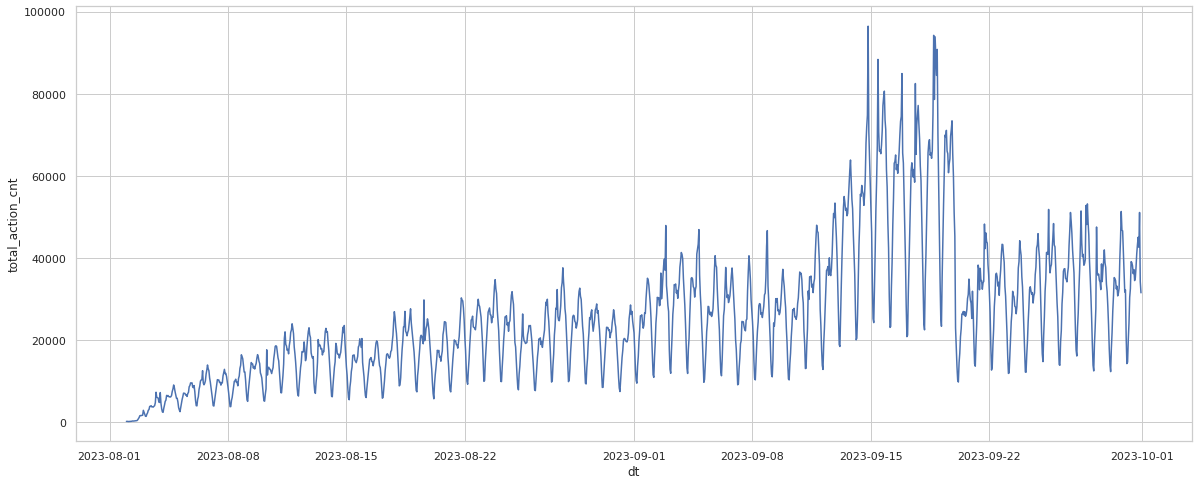

In [16]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='dt', y='total_action_cnt');

Так же посмотрим на часовую активность пользователей и следом построим heatmap часовой активности пользователей

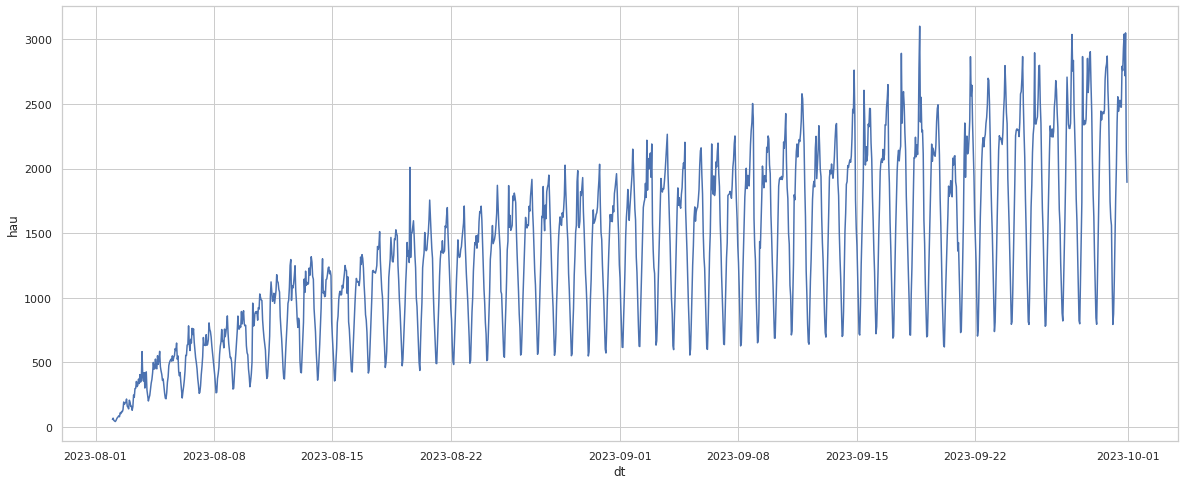

In [17]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='dt', y='hau');

Для построения прогноза по количеству действий, спрогнозируем метрику HAU (hour active users), и далее будем использовать ее вторым регрессором (первым регрессором будет flashmobe_reg - бинарный статус проводился ли флешмоб)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

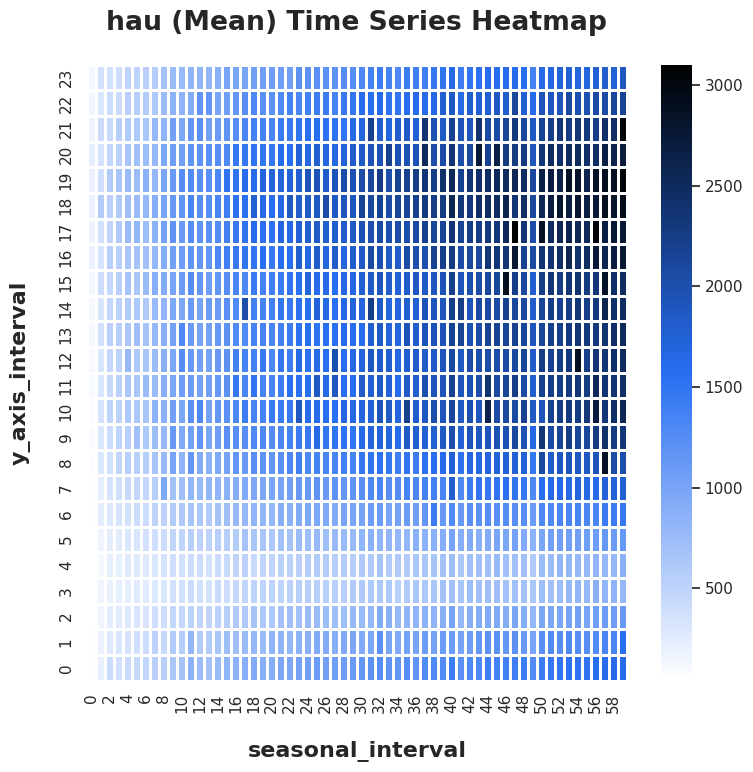

In [18]:
eda_plot.ts_heatmap(df=df, date_col="dt", value_col="hau", seasonal_interval=24, normalization=False);

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

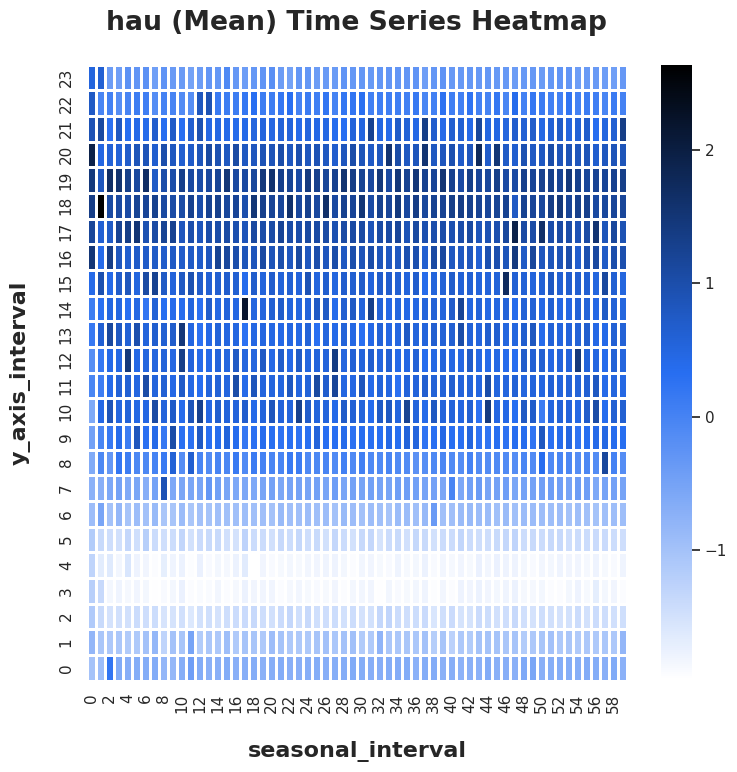

In [19]:
eda_plot.ts_heatmap(df=df, date_col="dt", value_col="hau", seasonal_interval=24, normalization=True);

По тепловым картам мы видим, что нагруженные часы и часы тишины, когда пользователей наименьшее количество не меняются. 

Нагруженные часа находятся между 17 и 21 часом

Часы тишины между 2 ночи и 5 утра

Создадим первую модель DLT, будем использовать регрессор проведение флэшмоба.

In [20]:
dlt = DLT(response_col="hau",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=['flashmobe_reg'], 
                regressor_sign=["+"],
                global_trend_option='loglinear',
                damped_factor = 0.25,
                seasonality_sm_input = 0.2
               ) 

2023-10-04 15:06:29 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


И попробуем сразу подобрать наиболее удобные параметры

In [21]:
best_params, tuned_df = grid_search_orbit(
                                        param_grid={
                                            "damped_factor": np.arange(0.2, 0.9, 0.3), 
                                            'global_trend_option': ['linear', 'loglinear'], 
                                            'seasonality_sm_input': np.arange(0.2, 0.5, 0.2), 
                                            'regressor_col': [['flashmobe_reg']]
                                        },
                                        model=dlt,
                                        df=df,
                                        min_train_len=24*24,
                                        incremental_len=24*4,
                                        forecast_len=24*8,
                                        metrics=None, 
                                        criteria="min", 
                                        verbose=True) 

  0%|          | 0/12 [00:00<?, ?it/s]

2023-10-04 15:06:29 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'linear', 'regressor_col': ['flashmobe_reg'], 'seasonality_sm_input': 0.2}
2023-10-04 15:06:29 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-04 15:06:29 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.
2023-10-04 15:08:22 - orbit - INFO - tuning metric:0.10137
2023-10-04 15:08:22 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'linear', 'regressor_col': ['flashmobe_reg'], 'seasonality_sm_input': 0.4}
2023-10-04 15:08:22 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-04 15:08:35 - orbit - INFO - tuning metric:0.082217
2023-10-04 15:08:35 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'loglinear', 'regressor_col': ['flashmobe_reg'], 'seasonality_sm_input': 0.2}
2023-10-04 15:08:35 - orbit - INFO - Optimizing (PyStan) with algorithm

In [22]:
best_params

[{'damped_factor': 0.8,
  'global_trend_option': 'loglinear',
  'regressor_col': ['flashmobe_reg'],
  'seasonality_sm_input': 0.4}]

In [23]:
tuned_df

,damped_factor,global_trend_option,regressor_col,seasonality_sm_input,metrics
0,0.2,linear,[flashmobe_reg],0.2,0.101373
1,0.2,linear,[flashmobe_reg],0.4,0.082217
2,0.2,loglinear,[flashmobe_reg],0.2,0.066458
3,0.2,loglinear,[flashmobe_reg],0.4,0.064182
4,0.5,linear,[flashmobe_reg],0.2,0.100955
5,0.5,linear,[flashmobe_reg],0.4,0.082919
6,0.5,loglinear,[flashmobe_reg],0.2,0.066891
7,0.5,loglinear,[flashmobe_reg],0.4,0.064644
8,0.8,linear,[flashmobe_reg],0.2,0.104258
9,0.8,linear,[flashmobe_reg],0.4,0.083239


Изменим нашу модель согласно наиболее удачной комбинации парамтеров
1. 'damped_factor': 0.8,
2. 'global_trend_option': 'loglinear',
3. 'regressor_col': 'flashmobe_reg',
4. 'seasonality_sm_input': 0.4

In [24]:
dlt = DLT(response_col="hau",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=['flashmobe_reg'], 
                regressor_sign=["+"],
                global_trend_option='loglinear',
                damped_factor = 0.8,
                seasonality_sm_input = 0.4
          
               ) 

2023-10-04 15:10:46 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Далее проведем обучение модели и посмотрим на результаты. Для начала будем использовать прогноз на 8 дней вперед. 

In [25]:
dlt.fit(df)

In [26]:
future_df_hau = dlt.make_future_df(periods=24*8)
future_df_hau['flashmobe_reg'] = 0
future_df_hau.head()

,dt,flashmobe_reg
0,2023-10-01 00:00:00,0
1,2023-10-01 01:00:00,0
2,2023-10-01 02:00:00,0
3,2023-10-01 03:00:00,0
4,2023-10-01 04:00:00,0


In [27]:
predicted_df = dlt.predict(df=future_df_hau)
predicted_df.head()

,dt,prediction_5,prediction,prediction_95
0,2023-10-01 00:00:00,1612.381511,1749.701647,1888.306101
1,2023-10-01 01:00:00,1405.611284,1549.055680,1689.628183
2,2023-10-01 02:00:00,1082.821104,1231.142609,1375.036229
3,2023-10-01 03:00:00,830.534979,974.929436,1119.491556
4,2023-10-01 04:00:00,834.491629,993.370159,1130.734366


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

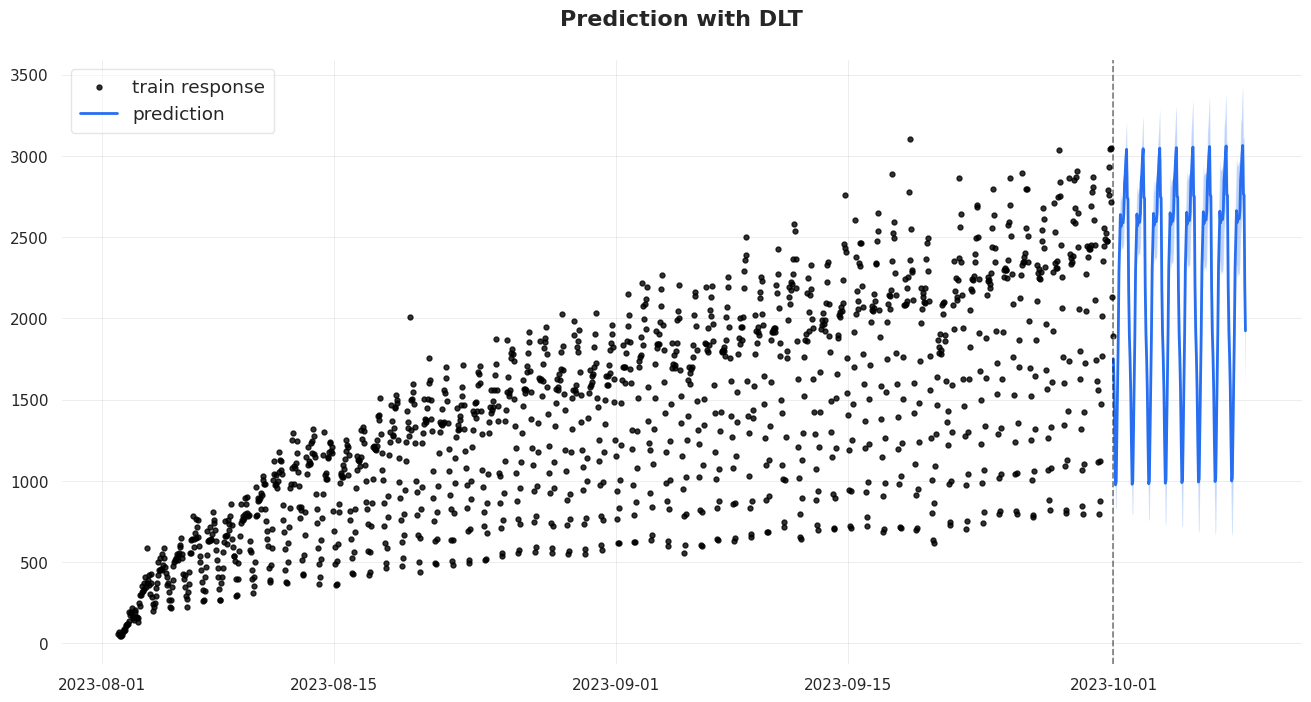

In [28]:
_ = plot_predicted_data(df, predicted_df, "dt", 'hau', title='Prediction with DLT')

Проведем оценку качества модели. 

Из полученной информации из открытых источников (в том числе библиотеки prophet) был сделан следующий вывод

Всего у нас (округлим в большую сторону) 60 дней по 24 часа

1. Минимально длина с которого начинается обучение данных должена быть равна длинне прогноза умноженной на 3 или 4
2. Прирост данных равняется половине прогноза
3. Имперически было получено, что количество шагов должно быть в диапазоне от 5 до 10

Таким образом получится 8 шагов

Другая рекомендация заключалась в следующем, что размер предсказания может быть равен 10-30% от имеющихся данных (6-18 дней).

Как следствие у нас похоже недостаточно данных для проведения прогноза по активности пользователей на ближайший месяц. 

Посмотрим на примере 8 дневного прогноза и 15 дневного прогноза. На сколько изменятся метрики

In [29]:
#rolling
bt_roll = BackTester(
    model=dlt,
    df=df,
    min_train_len=24*24,
    incremental_len=24*4,
    forecast_len=24*8,
    window_type="rolling",
)

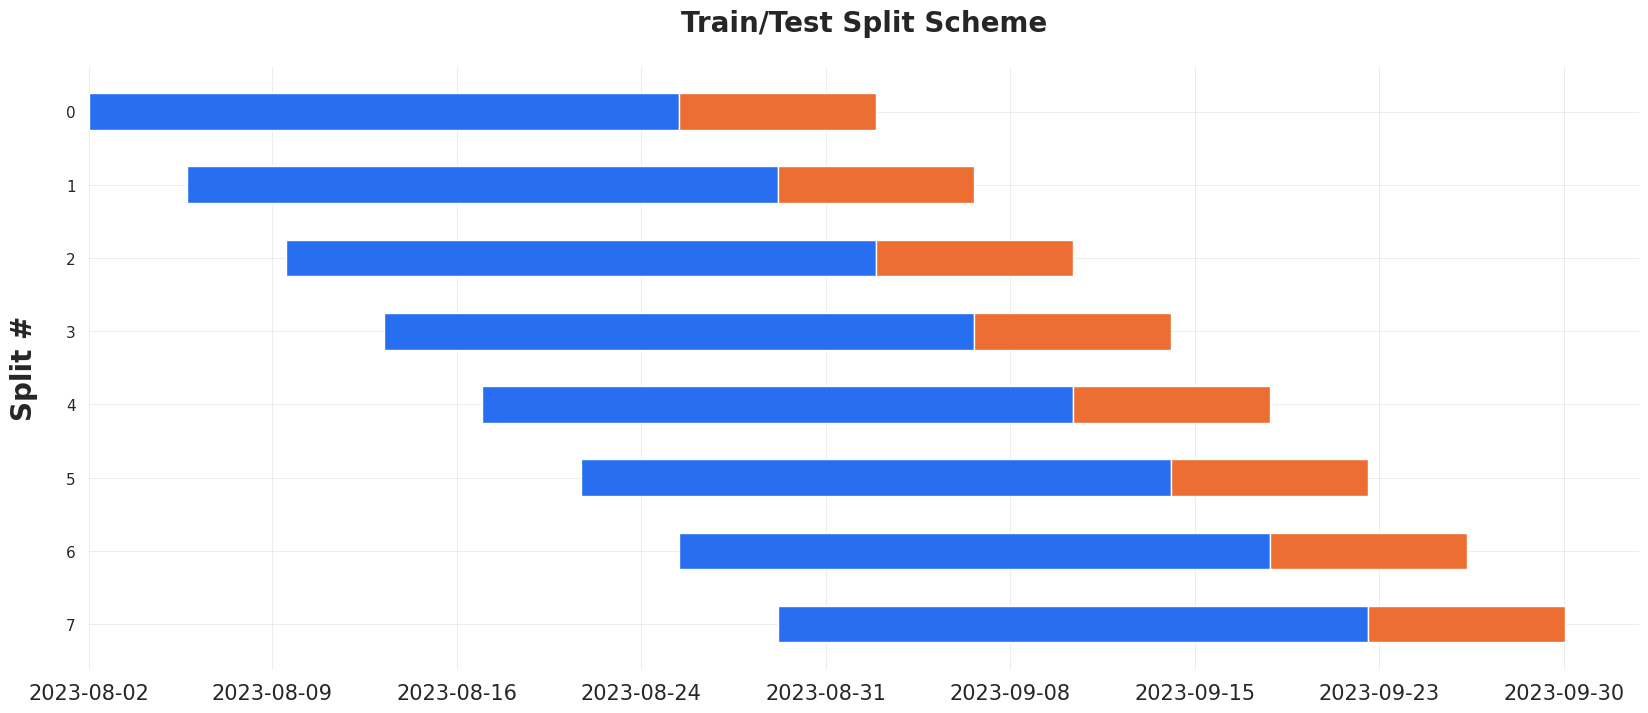

In [30]:
bt_roll.plot_scheme()

Обучим и посмотрим на значение метрик модели

In [31]:
bt_roll.fit_predict() 
bt_roll.score() 

,metric_name,metric_values,is_training_metric
0,smape,0.062065,False
1,wmape,0.060209,False
2,mape,0.062582,False
3,mse,22816.635596,False
4,mae,101.490166,False
5,rmsse,0.719323,False


Сделаем тоже самое для 15 дневного горизонта, но с сохранением параметров min_train_len и incremental_len

In [32]:
bt_roll_15 = BackTester(
    model=dlt,
    df=df,
    min_train_len=24*24,
    incremental_len=24*4,
    forecast_len=24*15,
    window_type="rolling",
)

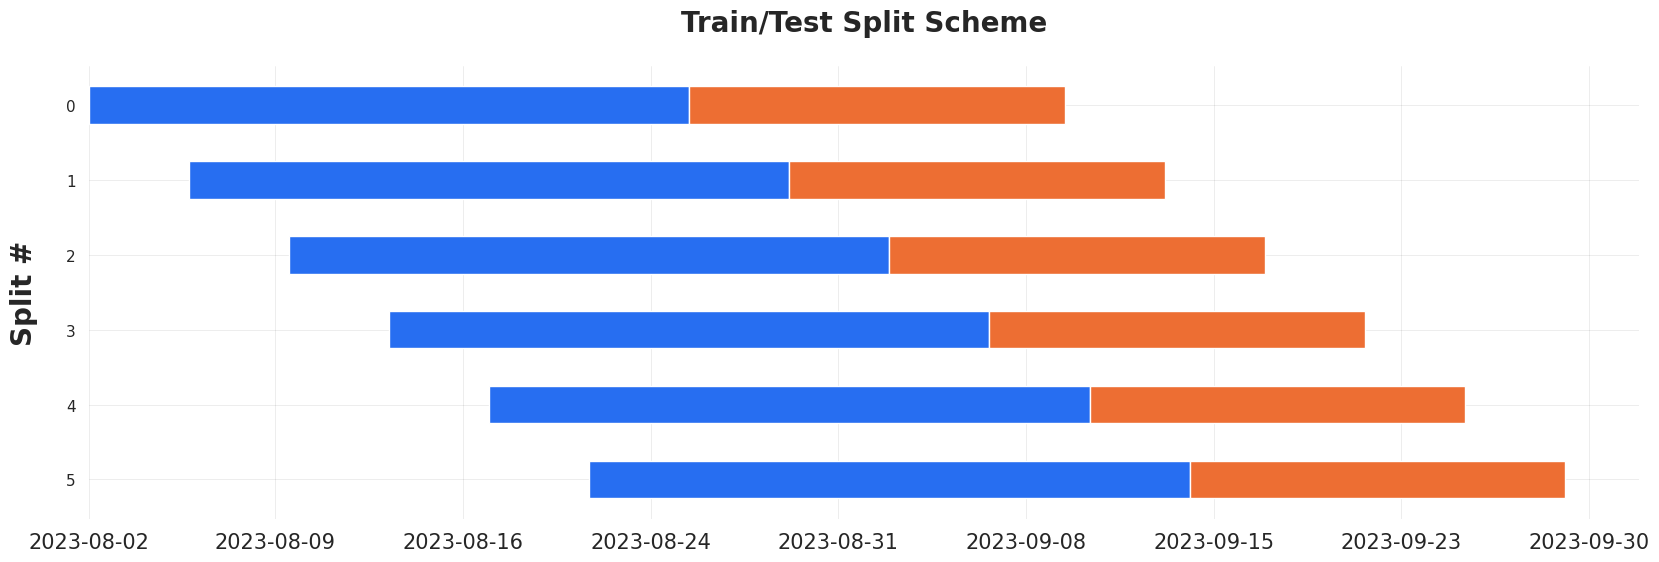

In [33]:
bt_roll_15.plot_scheme()

In [34]:
bt_roll_15.fit_predict() 
bt_roll_15.score() 

,metric_name,metric_values,is_training_metric
0,smape,0.075167,False
1,wmape,0.075532,False
2,mape,0.073648,False
3,mse,32064.179118,False
4,mae,126.603102,False
5,rmsse,0.854145,False


У данной модели с горизонтом предсказания 15 суток, по сравнению с горизонтом 8 суток ошибка MAE выросла на 24%, а rmsse почти на 20%. 

Посмотрим как активность пользователей предскажет модель на следующие 15 дней. Для этого разделим наш датафрейм на две выборки тренировочную (до 15 сентября) и тестовую (с 15 сентября).

In [35]:
train_dat = df.query("dt < '2023-09-15 00:00:00'") #возьмём часть данных для обучения
test_dat = df.query("dt >= '2023-09-15 00:00:00'").astype({"hau":"int64"}) #а это будем предсказывать 

In [36]:
reg_model = DLT(response_col="hau",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=['flashmobe_reg'], 
                regressor_sign=["+"],
                global_trend_option='loglinear',
                damped_factor = 0.8,
                seasonality_sm_input = 0.4
               ) 

2023-10-04 15:11:10 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [37]:
reg_model.fit(train_dat)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

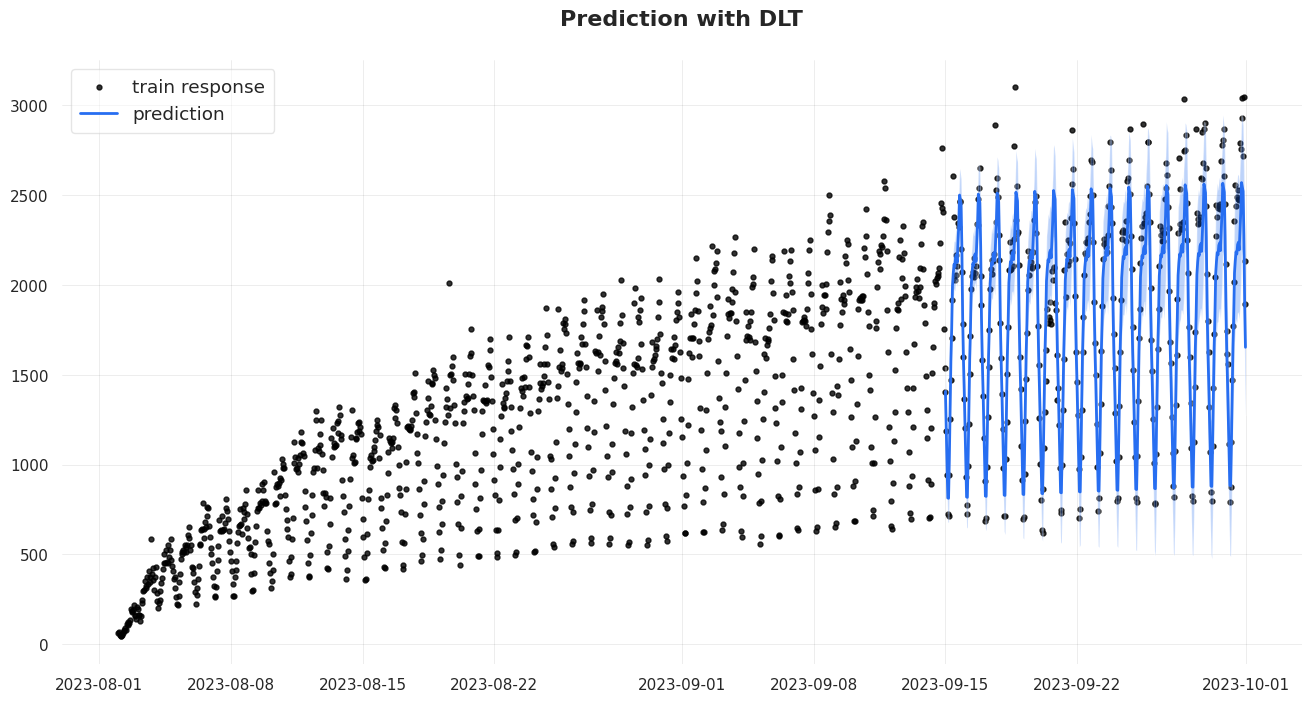

In [38]:
predicted_df_reg = reg_model.predict(df=test_dat)

_ = plot_predicted_data(df, predicted_df_reg, "dt", 'hau', title='Prediction with DLT') 

Как видим, где-то с 10 дня прогноз начинает недооценивать фактический рост, в связи остановимся на горизонте прогноза равному 8 дням

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                1440 non-null   datetime64[ns]
 1   hau               1440 non-null   int64         
 2   msg_actions_cnt   1440 non-null   uint64        
 3   feed_cnt          1440 non-null   uint64        
 4   total_action_cnt  1440 non-null   int64         
 5   flashmobe_reg     1440 non-null   int64         
dtypes: datetime64[ns](1), int64(3), uint64(2)
memory usage: 67.6 KB


С целью уменьшения дисперсия прологарифмируем по основанию ``e`` общее количество действий по основанию

Далее проведем те же действия. Создадим модель, подберем параметры модели и построим прогноз.
В этот раз будем использовать два алгоритма и выберем лучший
1. Maximum A Posteriori (MAP)
2. Markov Chain Monte Carlo (MCMC)

In [40]:
df['action_log'] = np.log(df['total_action_cnt'])

In [41]:
dlt_actions = DLT(response_col="action_log",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=[['flashmobe_reg', 'hau']], 
                regressor_sign=[['+', '+']],
                global_trend_option='loglinear',
                seasonality_sm_input = 0.4
               ) 

2023-10-04 15:11:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [42]:
best_params_action, tuned_df_action = grid_search_orbit(
                                        param_grid={
                                            "damped_factor": np.arange(0.2, 0.9, 0.3), 
                                            'global_trend_option': ['linear', 'loglinear'], 
                                            'seasonality_sm_input': np.arange(0.2, 0.5, 0.2), 
                                            'regressor_col': [['flashmobe_reg', 'hau']],
                                            'regressor_sign': [['+', '+']]
                                        }, 
                                        model=dlt_actions,
                                        df=df,
                                        min_train_len=24*24,
                                        incremental_len=24*4,
                                        forecast_len=24*8,
                                        metrics=None, 
                                        criteria="min", 
                                        verbose=True) 

  0%|          | 0/12 [00:00<?, ?it/s]

2023-10-04 15:11:13 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'linear', 'regressor_col': ['flashmobe_reg', 'hau'], 'regressor_sign': ['+', '+'], 'seasonality_sm_input': 0.2}
2023-10-04 15:11:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-04 15:11:32 - orbit - INFO - tuning metric:0.031811
2023-10-04 15:11:32 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'linear', 'regressor_col': ['flashmobe_reg', 'hau'], 'regressor_sign': ['+', '+'], 'seasonality_sm_input': 0.4}
2023-10-04 15:11:32 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-04 15:11:49 - orbit - INFO - tuning metric:0.031784
2023-10-04 15:11:49 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'global_trend_option': 'loglinear', 'regressor_col': ['flashmobe_reg', 'hau'], 'regressor_sign': ['+', '+'], 'seasonality_sm_input': 0.2}
2023-10-04 15:11:49 - orbit - INFO - Optimizing (PyStan) with algorithm:

In [43]:
best_params_action

[{'damped_factor': 0.2,
  'global_trend_option': 'loglinear',
  'regressor_col': ['flashmobe_reg', 'hau'],
  'regressor_sign': ['+', '+'],
  'seasonality_sm_input': 0.2}]

In [44]:
tuned_df_action

,damped_factor,global_trend_option,regressor_col,regressor_sign,seasonality_sm_input,metrics
0,0.2,linear,"[flashmobe_reg, hau]","[+, +]",0.2,0.031811
1,0.2,linear,"[flashmobe_reg, hau]","[+, +]",0.4,0.031784
2,0.2,loglinear,"[flashmobe_reg, hau]","[+, +]",0.2,0.027224
3,0.2,loglinear,"[flashmobe_reg, hau]","[+, +]",0.4,0.027516
4,0.5,linear,"[flashmobe_reg, hau]","[+, +]",0.2,0.031789
5,0.5,linear,"[flashmobe_reg, hau]","[+, +]",0.4,0.030533
6,0.5,loglinear,"[flashmobe_reg, hau]","[+, +]",0.2,0.027907
7,0.5,loglinear,"[flashmobe_reg, hau]","[+, +]",0.4,0.027923
8,0.8,linear,"[flashmobe_reg, hau]","[+, +]",0.2,0.031459
9,0.8,linear,"[flashmobe_reg, hau]","[+, +]",0.4,0.031377


In [45]:
dlt_actions = DLT(response_col="action_log",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=['flashmobe_reg', 'hau'], 
                regressor_sign=['+', '+'],
                global_trend_option='loglinear',
                seasonality_sm_input = 0.2,
                damped_factor= 0.2
               ) 

2023-10-04 15:15:01 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [46]:
dlt_actions.fit(df)

In [47]:
future_df_actions = dlt_actions.make_future_df(periods=24*8) \
                               .merge(predicted_df[['dt', 'prediction']], on='dt').rename(columns={'prediction': 'hau'})  
future_df_actions['flashmobe_reg'] = 0
future_df_actions.head()

,dt,hau,flashmobe_reg
0,2023-10-01 00:00:00,1749.701647,0
1,2023-10-01 01:00:00,1549.055680,0
2,2023-10-01 02:00:00,1231.142609,0
3,2023-10-01 03:00:00,974.929436,0
4,2023-10-01 04:00:00,993.370159,0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

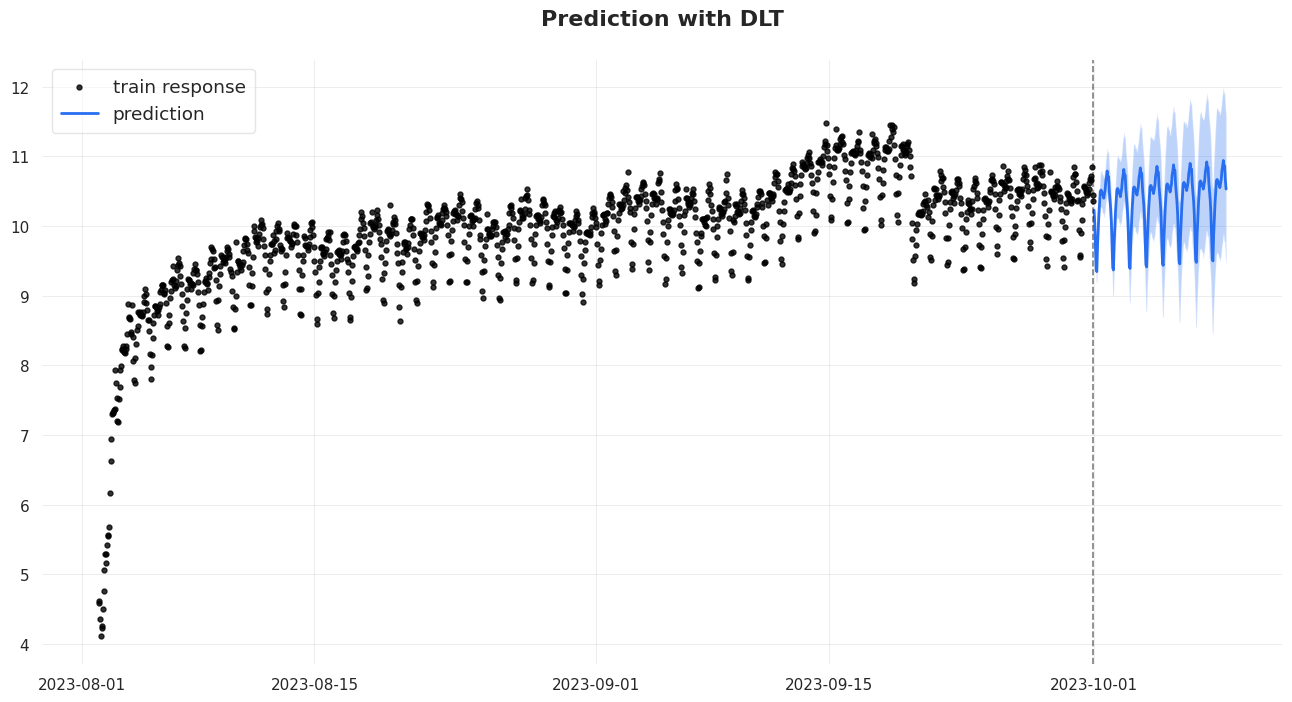

In [48]:
predicted_df_action = dlt_actions.predict(df=future_df_actions)
_ = plot_predicted_data(df, predicted_df_action, "dt", 'action_log', title='Prediction with DLT')

In [49]:
bt_roll_action = BackTester(
    model=dlt_actions,
    df=df,
    min_train_len=24*24,
    incremental_len=24*4,
    forecast_len=24*8,
    window_type="rolling",
)

In [50]:
bt_roll_action.fit_predict() 
bt_roll_action.score() 

,metric_name,metric_values,is_training_metric
0,smape,0.027757,False
1,wmape,0.028113,False
2,mape,0.027965,False
3,mse,0.163403,False
4,mae,0.290058,False
5,rmsse,2.420719,False


In [51]:
dlt_action_mcmc = DLT(response_col="action_log",
          date_col="dt",
          seasonality=24,
          estimator="stan-mcmc",  
          num_warmup=4000, #время "разогрева"
          num_sample=2000, #время сэмплирования
          regressor_col=['flashmobe_reg', 'hau'], 
          regressor_sign=['+', '+']
             )

dlt_action_mcmc.fit(df)

2023-10-04 15:15:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

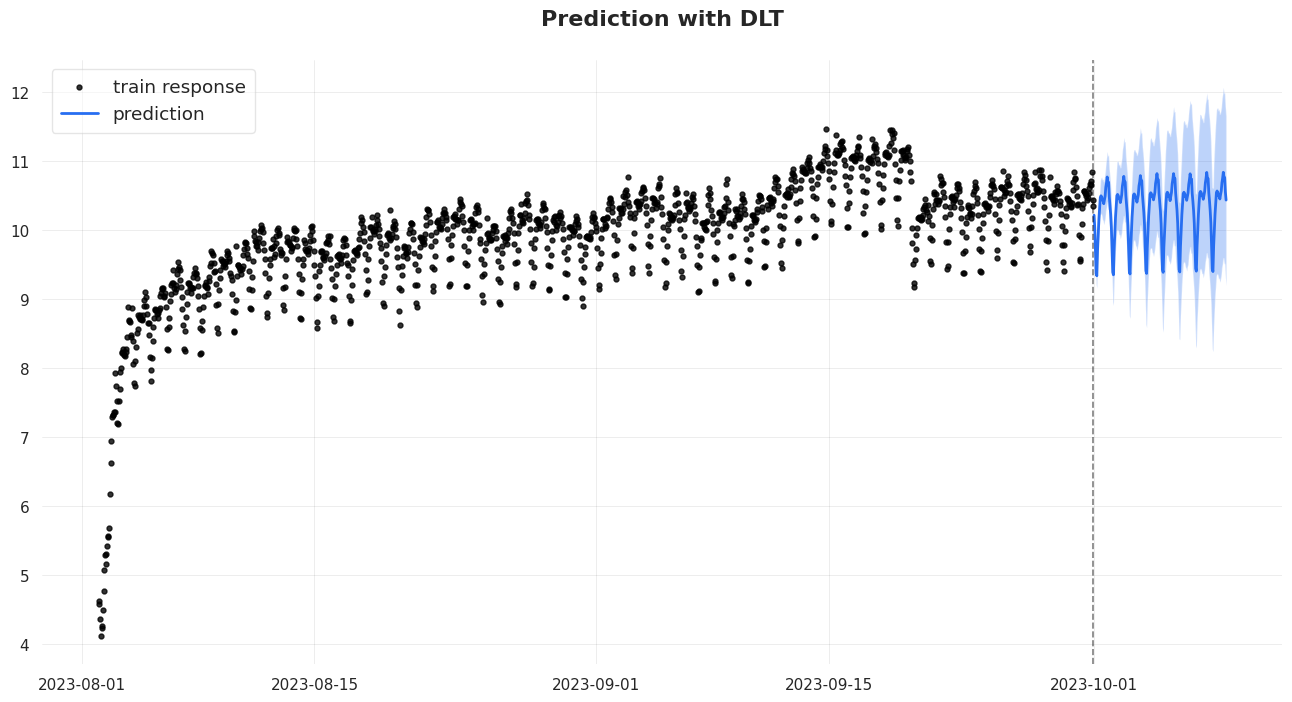

In [52]:
predicted_df_dtl_mcmc = dlt_action_mcmc.predict(df=future_df_actions)

_ = plot_predicted_data(df, predicted_df_dtl_mcmc, "dt", 'action_log', title='Prediction with DLT')

In [53]:
bt_roll_action_mcmc = BackTester(
    model=dlt_action_mcmc,
    df=df,
    min_train_len=24*24,
    incremental_len=24*4,
    forecast_len=24*8,
    window_type="rolling",
)

In [54]:
bt_roll_action_mcmc.fit_predict() 
bt_roll_action_mcmc.score() 

2023-10-04 15:26:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:30:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:33:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:36:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:45:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-10-04 15:48:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,0.024749,False
1,wmape,0.025273,False
2,mape,0.025407,False
3,mse,0.165908,False
4,mae,0.260760,False
5,rmsse,2.439206,False


In [55]:
params = dlt_action_mcmc.get_posterior_samples(permute=False) 

params.keys() 

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'beta', 'gt_sum', 'gb', 'gl', 'loglk'])

In [56]:
params["obs_sigma"].shape 

(4, 500)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

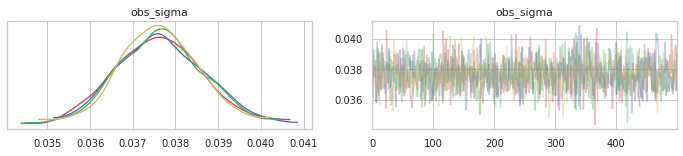

In [57]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

Цепи сошлись, значит разные цепи алгоритма пришли к одному и тому же выводу

Переведем метрику из логарифмической в обычную шкалу и посмотрим на результат (возьмем модель обученную алгоритмом MAP)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

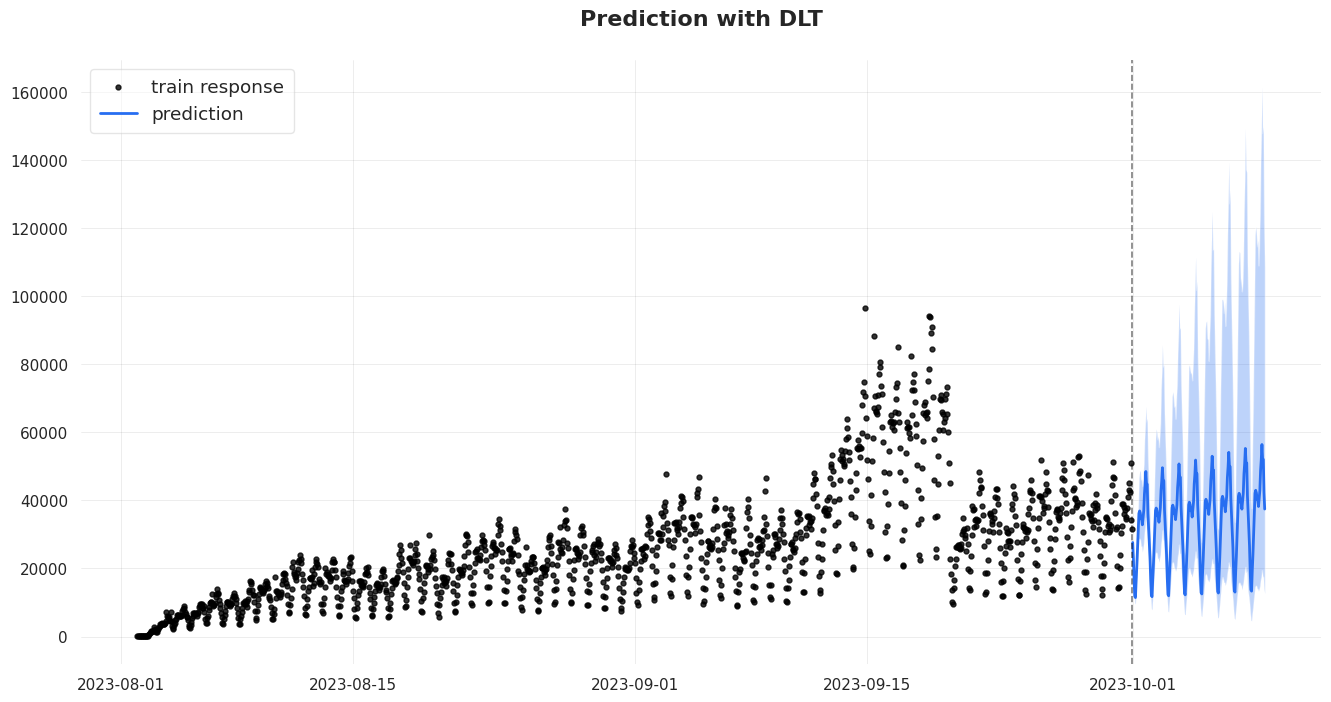

In [58]:
_ = plot_predicted_data(df, (np.e**predicted_df_action.set_index('dt')).reset_index(), "dt", 'total_action_cnt', title='Prediction with DLT')

Видим огромные доверительные интервалы.

Попробуем построить модель без логарифмирования переменной отражающей активность пользователей

In [59]:
dlt_actions_lin = DLT(response_col="total_action_cnt",
                date_col="dt", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=2000, 
                regressor_col=['flashmobe_reg', 'hau'], 
                regressor_sign=['+', '+'],
                global_trend_option='loglinear',
                seasonality_sm_input = 0.2,
                damped_factor= 0.8,
                global_floor=5000
               ) 

2023-10-04 15:51:04 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [60]:
dlt_actions_lin.fit(df)

In [61]:
future_df_actions_lin = dlt_actions_lin.make_future_df(periods=24*8) \
                               .merge(predicted_df[['dt', 'prediction']], on='dt').rename(columns={'prediction': 'hau'})  
future_df_actions_lin['flashmobe_reg'] = 0
future_df_actions_lin.head()

,dt,hau,flashmobe_reg
0,2023-10-01 00:00:00,1749.701647,0
1,2023-10-01 01:00:00,1549.055680,0
2,2023-10-01 02:00:00,1231.142609,0
3,2023-10-01 03:00:00,974.929436,0
4,2023-10-01 04:00:00,993.370159,0


In [62]:
predicted_df_lin = dlt_actions_lin.predict(df=future_df_actions_lin)
predicted_df_lin.head()

,dt,prediction_5,prediction,prediction_95
0,2023-10-01 00:00:00,21312.341787,26108.205182,30874.393953
1,2023-10-01 01:00:00,15853.993268,21086.320699,25906.445829
2,2023-10-01 02:00:00,6928.967586,12265.239184,17622.346361
3,2023-10-01 03:00:00,768.796515,6145.420479,12002.655902
4,2023-10-01 04:00:00,-636.585009,5312.544664,11225.185475


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

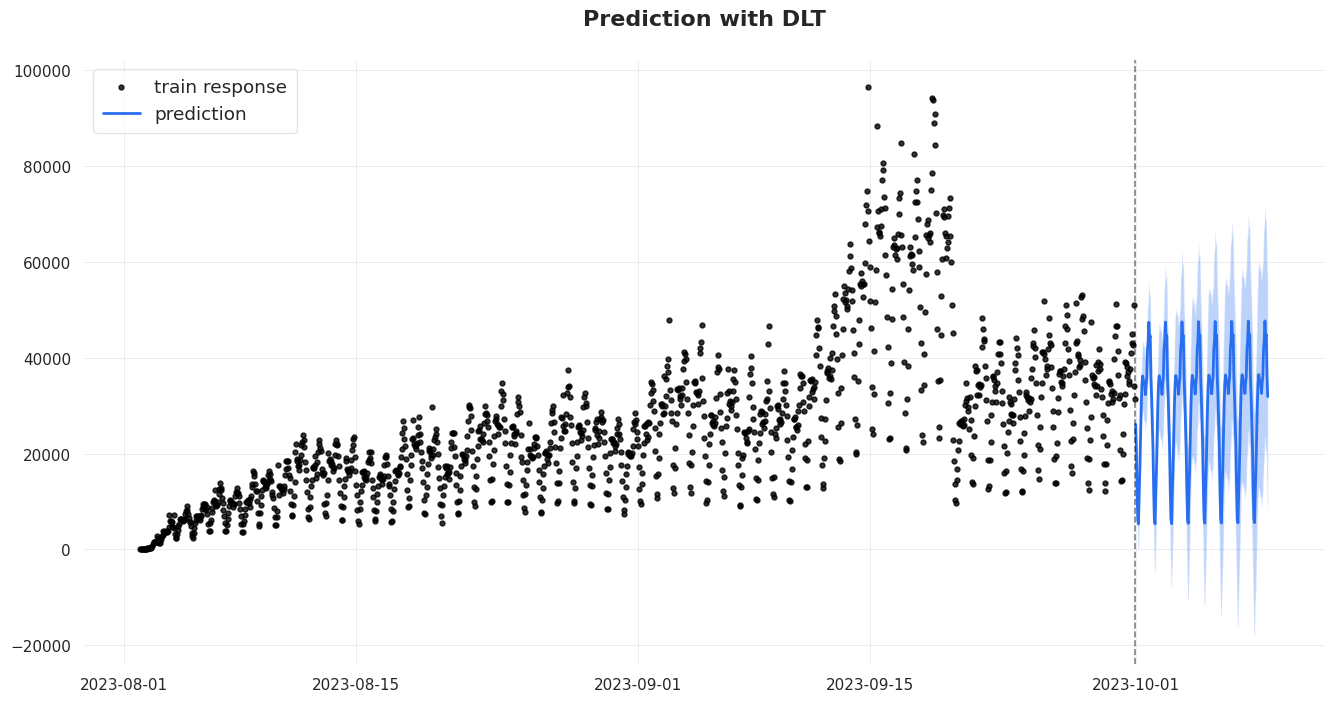

In [63]:
_ = plot_predicted_data(df, predicted_df_lin, "dt", 'total_action_cnt', title='Prediction with DLT')

Доверительные интервалы тоже достаточно широки, к тому же они уходят в минусовую область, но на общий вывод это особо не повлияет. 

In [64]:
bt_roll_action_lin = BackTester(
    model=dlt_actions_lin,
    df=df,
    min_train_len=24*24,
    incremental_len=24*4,
    forecast_len=24*8,
    window_type="rolling",
)

In [65]:
bt_roll_action_lin.fit_predict()
bt_roll_action_lin.score() 

,metric_name,metric_values,is_training_metric
0,smape,3.282257e-01,False
1,wmape,3.716746e-01,False
2,mape,4.130086e-01,False
3,mse,3.655575e+08,False
4,mae,1.260224e+04,False
5,rmsse,3.674748e+00,False


In [66]:
bt_roll_action.score()

,metric_name,metric_values,is_training_metric
0,smape,0.027757,False
1,wmape,0.028113,False
2,mape,0.027965,False
3,mse,0.163403,False
4,mae,0.290058,False
5,rmsse,2.420719,False


In [67]:
bt_roll_action_mcmc.score()

,metric_name,metric_values,is_training_metric
0,smape,0.024749,False
1,wmape,0.025273,False
2,mape,0.025407,False
3,mse,0.165908,False
4,mae,0.260760,False
5,rmsse,2.439206,False


## ВЫВОД

Было обучено 2 модели (алгоритмы MAP и MCMC) поверх прологорифмированной метрики. 1 модель (алгоритм MAP) поверх метрики в естественном виде, и еще одна модель для предсказания HAU (алгоритм MAP). На горизонт прогноза не было запланировано проведения каких-то акций, флешмобов и т.п. вещей, которые могли повлиять на рост числа пользователей.

При обучении 3-х моделей для предсказания основной метрики использовалось 2 предиктора.
1. flashmobe_reg - бинарный показатель наличия флешмоба (1 - проходил, 0 - не было)
2. HAU - количество уникальных пользователей в ед. времени

Предсказание проводилось на горизонт равный 8 суткам. Данных для предсказания на более длительный период нехватало (расчеты приведены по ходу исследования)

Остановимся на модели посчитанной алгоритмом MAP поверх пролагарифмированной метрики. Она обучается достаточно быстро, и дает схожие результаты с остальными моделями (единсвтенное у нее самые большие показатели 95% доверительного интервала)

In [68]:
total = (np.e**predicted_df_action.set_index('dt')).reset_index()
total['hour'] = total['dt'].dt.hour

Отобразим на графике
1. историческую почасовую нагрузки в период с 23.09.2023 - 30.09.2023
2. Предсказанные значения на период 01.10.2023 - 08.10.2023

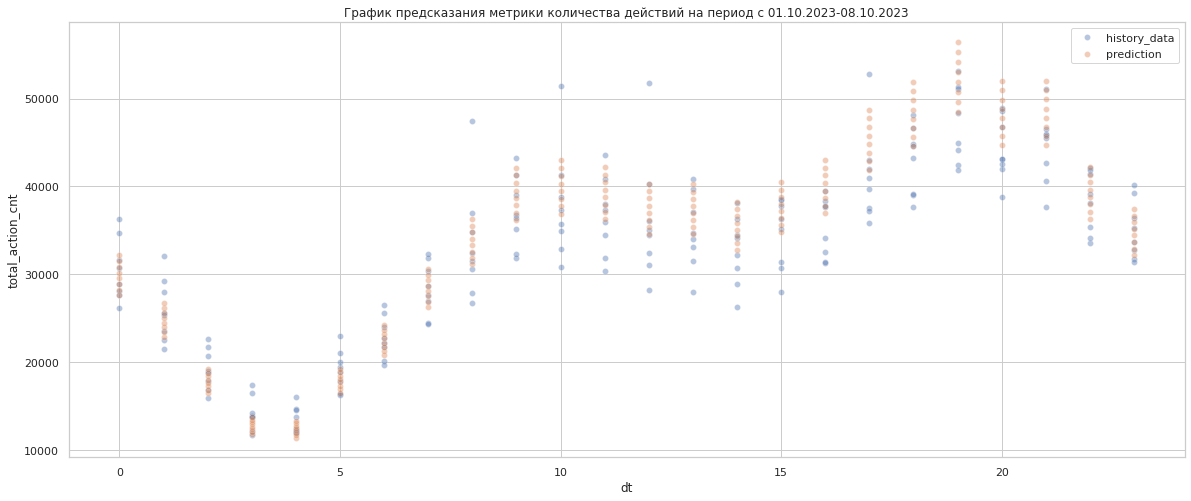

In [69]:
plt.figure(figsize=(20,8))
sns.scatterplot(df, x=df.query('dt >= "2023-09-23"')['dt'].dt.hour, y='total_action_cnt', alpha=0.4, label='history_data')
sns.scatterplot(total, x='hour', y='prediction', alpha=0.4, label='prediction')
plt.title('График предсказания метрики количества действий на период с 01.10.2023-08.10.2023')
plt.show()

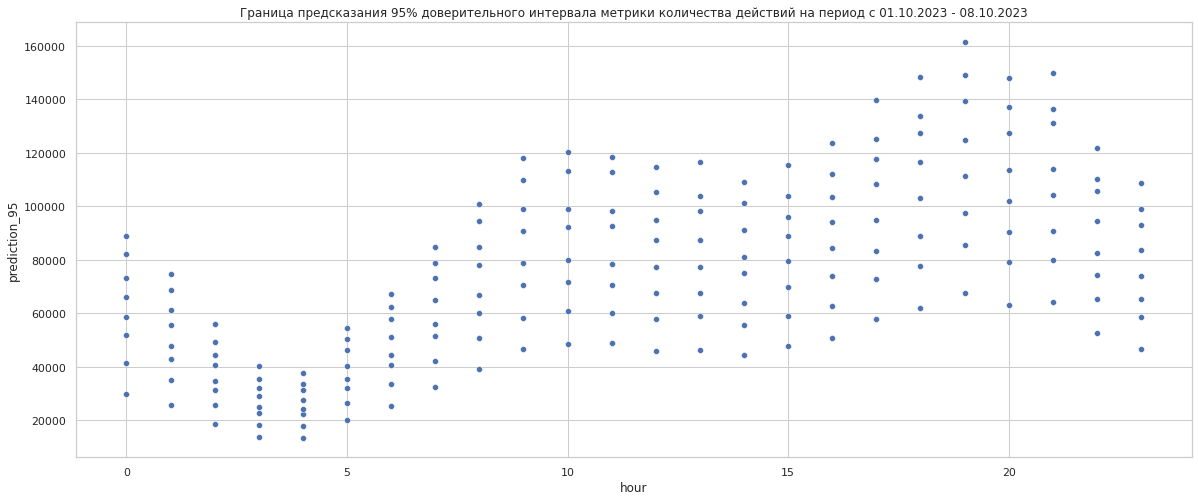

In [70]:
plt.figure(figsize=(20,8))
sns.scatterplot(total, x='hour', y='prediction_95')
plt.title('Граница предсказания 95% доверительного интервала метрики количества действий на период с 01.10.2023 - 08.10.2023')
plt.show()

В целом наши модели прогнозируют продолжение небольшого роста пользователей, и планомерное увеличение нагрузки (о падении нагрузки на сервера пока данные не говорят). В нагруженные вечерние часы ожидается 35-60 тыс. операций (чуть больше чем за предыдущие 8 дней). Если пользователи столкнулись с подвисанием приложения на текущий момент, то сейчас самое время заняться ее решением, так как рост пользователей и нагрузки сейчас достаточно плавный и у нас есть предсказания модели, чего стоит ожидать в краткосрочной перспективе.  